## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam 
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image

C:\Users\abhij\AppData\Local\Temp\ipykernel_13948\4019452423.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Getting the path of the training and testing data of the brain tumor dataset

In [2]:
dataset_directory_location = r'C:\Users\abhij\Desktop\Image Classification\braintumordataset'

In [3]:
os.listdir(dataset_directory_location)

['Testing', 'Training', 'Validation']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'Training')
valid_dataset_location = os.path.join(dataset_directory_location, 'Validation')
test_dataset_location = os.path.join(dataset_directory_location, 'Testing')

In [5]:
os.listdir(train_dataset_location)

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
os.listdir(test_dataset_location)

['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
os.listdir(valid_dataset_location)

['glioma', 'meningioma', 'notumor', 'pituitary']

## Defining the correct shape of the image

In [8]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=32,
    color_mode='rgb', 
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    valid_dataset_location,
    target_size=correct_image_shape[:2],
    batch_size=32,
    color_mode='rgb', 
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dataset_location,
    target_size=correct_image_shape[:2],
    color_mode='rgb', 
    batch_size=32,
    class_mode='categorical'
)

Found 5617 images belonging to 4 classes.
Found 703 images belonging to 4 classes.
Found 703 images belonging to 4 classes.


## Creating and training the model

In [11]:
model = Sequential()

In [12]:
get_inception_v3_pretrained_model = "https://www.kaggle.com/models/google/inception-v3/frameworks/TensorFlow2/variations/classification/versions/2"

In [13]:
inception_v3_pretrained_model = hub.KerasLayer(get_inception_v3_pretrained_model, input_shape=correct_image_shape, trainable=False) 

In [14]:
model.add(inception_v3_pretrained_model)

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              23853833  
                                                                 
 batch_normalization (BatchN  (None, 1001)             4004      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               128256    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4

In [16]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(train_generator, validation_data=val_generator, epochs=30,callbacks=[early_stopping])

Epoch 1/30
176/176 [==============================] - 98s 502ms/step - loss: 2.1608 - accuracy: 0.2578 - val_loss: 1.6470 - val_accuracy: 0.3073
Epoch 2/30
176/176 [==============================] - 75s 425ms/step - loss: 1.8665 - accuracy: 0.3327 - val_loss: 1.4729 - val_accuracy: 0.4196
Epoch 3/30
176/176 [==============================] - 76s 433ms/step - loss: 1.7041 - accuracy: 0.3669 - val_loss: 1.3376 - val_accuracy: 0.4723
Epoch 4/30
176/176 [==============================] - 77s 440ms/step - loss: 1.5398 - accuracy: 0.4194 - val_loss: 1.2308 - val_accuracy: 0.5178
Epoch 5/30
176/176 [==============================] - 110s 628ms/step - loss: 1.4363 - accuracy: 0.4547 - val_loss: 1.1487 - val_accuracy: 0.5605
Epoch 6/30
176/176 [==============================] - 129s 732ms/step - loss: 1.3431 - accuracy: 0.4887 - val_loss: 1.0890 - val_accuracy: 0.5903
Epoch 7/30
176/176 [==============================] - 118s 671ms/step - loss: 1.2734 - accuracy: 0.5065 - val_loss: 1.0377 - val

In [18]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

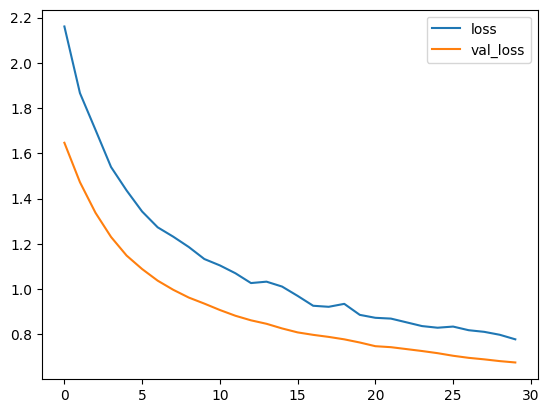

In [19]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

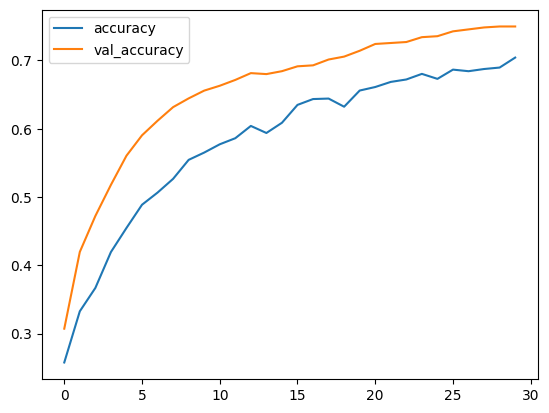

In [20]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

22/22 [==============================] - 3s 112ms/step - loss: 0.5433 - accuracy: 0.7824
Test Loss: 0.5433441400527954
Test Accuracy: 0.7823613286018372


## Predicting on a sample image

In [22]:
img_path = r'C:\Users\abhij\Desktop\Image Classification\braintumordataset\Testing\glioma\Te-gl_0191.JPG'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [23]:
predictions = model.predict(img_array)
class_names = ['glioma', 'meningioma','notumor','pituitary']
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
print(predicted_class)

1/1 [==============================] - 2s 2s/step
glioma
